In [1]:
import json
import pandas as pd
import numpy as np
from sklearn import model_selection
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Embedding, Dropout, LSTM, SpatialDropout1D, GRU, SimpleRNN
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import plot_model

#### Data load

In [ ]:
f = open('/content/drive/MyDrive/mvi/arxiv-metadata-oai-snapshot.json',)

dictionary = []
for line in f:
  dictionary.append([json.loads(line)['categories'],
                    json.loads(line)['authors'], 
                    json.loads(line)['title'], 
                    json.loads(line)['abstract']])

In [ ]:
df = pd.DataFrame(dictionary, columns=['categories', 'authors', 'title', 'abstract'])

In [ ]:
f.close()

In [ ]:
df.isnull().sum()

categories    0
authors       0
title         0
abstract      0
dtype: int64

In [ ]:
df.head()

categories  ...                                           abstract
0           hep-ph  ...    A fully differential calculation in perturba...
1    math.CO cs.CG  ...    We describe a new algorithm, the $(k,\ell)$-...
2   physics.gen-ph  ...    The evolution of Earth-Moon system is descri...
3          math.CO  ...    We show that a determinant of Stirling cycle...
4  math.CA math.FA  ...    In this paper we show how to compute the $\L...

[5 rows x 4 columns]

#### Preprocessing of text
Column Authors

In [ ]:
df.authors = df.authors.str.replace('\'', '').str.replace('et al', '').str.replace('[0-9]', '').str.replace('.', '').str.replace(',', '').str.replace('\\', '').str.replace('(', '').str.replace(')', '').str.replace('\\n', '').str.replace('-', '').str.replace('\"', '').str.replace('{', '').str.replace('}', '').str.replace('/', '').str.replace('and', '')

Removing symbols of first names

In [ ]:
for i, row in enumerate(df.authors.to_numpy()):
  row = row.split(' ')
  for r in row:
    if len(r) < 2:
      row.remove(r)
  df.iloc[i, df.columns.get_loc('authors')] = ' '.join(row)

Column Title

In [ ]:
df.title = df.title.str.replace('\\n', '').str.replace('\$', '').str.replace('\\', '').str.replace('{', '').str.replace('}', '')

Column Abstract

In [ ]:
df.abstract = df.abstract.str.replace('\$', '').str.replace('\\n', '').str.replace('\\', '')

Creating of new column with text from columns Authors, Title and Abstract

In [ ]:
df['text'] = df.authors + ' ' + df.title + ' ' + df.abstract

In [ ]:
df = df.drop(['authors', 'title', 'abstract'], axis=1)

In [ ]:
df.text = df.text.str.lower()

In [ ]:
df.head()

categories                                               text
0           hep-ph  balazs l berger m nadolsky cp yuan calculation...
1    math.CO cs.CG  ileana streinu louis theran sparsity-certifyin...
2   physics.gen-ph  hongjun pan the evolution of the earth-moon sy...
3          math.CO  david callan a determinant of stirling cycle n...
4  math.CA math.FA  wael abushammala alberto torchinsky from dyadi...

Preprocessnig of the target value Categories. Names of class values takes from https://arxiv.org/category_taxonomy

In [ ]:
df.shape

(1978109, 2)

In [ ]:
classes = ['cs', 'econ', 'eess', 'math', 'astro-ph', 'cond-mat', 'gr-qc', 'hep-ex', 'hep-lat', 'hep-ph', 'hep-th', 'math-ph', 'nlin', 'nucl-ex', 'nucl-th', 'physics', 'quant-ph', 'q-bio', 'q-fin', 'stat']

for cl in classes:
  df[cl] = 0

In [ ]:
'''
for i, cat in enumerate(df.categories.to_numpy()):
  if i > 1930000:
    cat = cat.split()
    for c in cat:
      if '.' in c:
        c = c.split('.')
        c = c[0]
      try:
        df.iloc[i, df.columns.get_loc(c)] = 1
      except KeyError as error:
        print(cat)
      if i%10000 == 0:
        print(i, cat, c)
        df.to_pickle("/content/drive/MyDrive/mvi/df1.pkl")
df.to_pickle("/content/drive/MyDrive/mvi/df1.pkl")
'''

In [ ]:
#df.to_pickle("/content/drive/MyDrive/mvi/df.pkl")
#df = pd.read_pickle("/content/drive/MyDrive/mvi/df1.pkl")

In [ ]:
df.head()

cs  econ  eess  math  astro-ph  ...  physics  quant-ph  q-bio  q-fin  stat
0   0     0     0     0         0  ...        0         0      0      0     0
1   1     0     0     1         0  ...        0         0      0      0     0
2   0     0     0     0         0  ...        1         0      0      0     0
3   0     0     0     1         0  ...        0         0      0      0     0
4   0     0     0     1         0  ...        0         0      0      0     0

[5 rows x 20 columns]

In [2]:
Text = pd.read_pickle("/content/drive/MyDrive/mvi/Text.pkl")
Target = pd.read_pickle("/content/drive/MyDrive/mvi/Target.pkl")

#### Train/ test split

In [3]:
Text_train, Text_test, Target_train, Target_test = model_selection.train_test_split(Text, Target, test_size=0.3, random_state=23) 

In [4]:
word_count = 15000
max_text_len = 500

Create tokenizer and specify the number of used words

In [ ]:
tokenizer = Tokenizer(num_words=word_count)

Train the tokenizer on the text corpus

In [ ]:
tokenizer.fit_on_texts(Text_train)

In [ ]:
tokenizer.word_index

{'the': 1,
 'of': 2,
 'and': 3,
 'a': 4,
 'in': 5,
 'to': 6,
 'we': 7,
 'is': 8,
 'for': 9,
 'that': 10,
 'with': 11,
 'on': 12,
 'this': 13,
 'by': 14,
 'are': 15,
 'as': 16,
 'an': 17,
 'from': 18,
 'be': 19,
 'which': 20,
 'at': 21,
 '1': 22,
 '2': 23,
 'model': 24,
 'can': 25,
 'it': 26,
 '0': 27,
 'our': 28,
 'two': 29,
 'n': 30,
 'data': 31,
 'using': 32,
 'these': 33,
 'show': 34,
 'results': 35,
 'based': 36,
 'time': 37,
 'also': 38,
 'or': 39,
 'field': 40,
 'have': 41,
 'quantum': 42,
 'one': 43,
 'x': 44,
 'such': 45,
 'between': 46,
 'study': 47,
 'paper': 48,
 'has': 49,
 '3': 50,
 'energy': 51,
 'non': 52,
 'theory': 53,
 'system': 54,
 'models': 55,
 'not': 56,
 'new': 57,
 'k': 58,
 'state': 59,
 'method': 60,
 'high': 61,
 'm': 62,
 'e': 63,
 'systems': 64,
 'order': 65,
 's': 66,
 'i': 67,
 'present': 68,
 'space': 69,
 'mass': 70,
 'its': 71,
 'large': 72,
 'p': 73,
 'their': 74,
 'problem': 75,
 't': 76,
 'g': 77,
 'all': 78,
 'well': 79,
 'first': 80,
 'both': 81,

In [5]:
import pickle

# saving
#with open('/content/drive/MyDrive/mvi/tokenizer.pickle', 'wb') as handle:
#    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# loading
with open('/content/drive/MyDrive/mvi/tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

Transform the text into numeric representation

In [6]:
Sequences_train = tokenizer.texts_to_sequences(Text_train)

Restrict the text length

In [7]:
x_train = pad_sequences(Sequences_train, maxlen=max_text_len)

#### RNN 1 layer

In [8]:
model_rnn = Sequential()
model_rnn.add(Embedding(word_count, 128, input_length=max_text_len))
model_rnn.add(SpatialDropout1D(0.5))
model_rnn.add(SimpleRNN(40))
model_rnn.add(Dense(20, activation='sigmoid'))

In [9]:
model_rnn.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy', 'AUC'])

In [ ]:
model_rnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 128)          1920000   
                                                                 
 spatial_dropout1d (SpatialD  (None, 500, 128)         0         
 ropout1D)                                                       
                                                                 
 simple_rnn (SimpleRNN)      (None, 40)                6760      
                                                                 
 dense (Dense)               (None, 20)                820       
                                                                 
Total params: 1,927,580
Trainable params: 1,927,580
Non-trainable params: 0
_________________________________________________________________


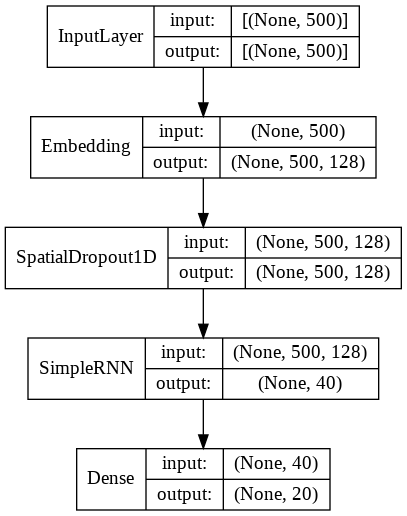

In [14]:
plot_model(model_rnn, show_layer_names=False, show_shapes=True)

In [ ]:
model_rnn_save_path = '/content/drive/MyDrive/mvi/best_model_rnn1_all_data_dropout.h5'
checkpoint_callback = [ModelCheckpoint(model_rnn_save_path, 
                                      monitor='val_accuracy',
                                      save_best_only=True,
                                      verbose=1),
                      EarlyStopping(monitor='val_loss', 
                                    mode='min', 
                                    verbose=1, 
                                    patience=10)]

In [ ]:
model_rnn.fit(x_train, 
              Target_train, 
              epochs=100,
              batch_size=512,
              validation_split=0.2,
              callbacks=checkpoint_callback)

Epoch 1/100
2164/2164 [==============================] - ETA: 0s - loss: 0.1843 - accuracy: 0.4777 - auc: 0.8505
Epoch 00001: val_accuracy improved from -inf to 0.59185, saving model to /content/drive/MyDrive/mvi/best_model_rnn1_all_data_dropout.h5
2164/2164 [==============================] - 1852s 855ms/step - loss: 0.1843 - accuracy: 0.4777 - auc: 0.8505 - val_loss: 0.1546 - val_accuracy: 0.5918 - val_auc: 0.9013
Epoch 2/100
2164/2164 [==============================] - ETA: 0s - loss: 0.1532 - accuracy: 0.5723 - auc: 0.9049
Epoch 00002: val_accuracy improved from 0.59185 to 0.60635, saving model to /content/drive/MyDrive/mvi/best_model_rnn1_all_data_dropout.h5
2164/2164 [==============================] - 1851s 855ms/step - loss: 0.1532 - accuracy: 0.5723 - auc: 0.9049 - val_loss: 0.1435 - val_accuracy: 0.6063 - val_auc: 0.9214
Epoch 3/100
2164/2164 [==============================] - ETA: 0s - loss: 0.1497 - accuracy: 0.5947 - auc: 0.9073
Epoch 00003: val_accuracy did not improve from

In [ ]:
model_rnn = load_model('/content/drive/MyDrive/mvi/best_model_rnn1_all_data_dropout.h5')

In [ ]:
model_rnn.fit(x_train, 
              Target_train, 
              epochs=100,
              batch_size=512,
              validation_split=0.2,
              callbacks=checkpoint_callback)

Epoch 1/100
2164/2164 [==============================] - ETA: 0s - loss: 0.1410 - accuracy: 0.6210 - auc: 0.9203
Epoch 00001: val_accuracy improved from -inf to 0.66183, saving model to /content/drive/MyDrive/mvi/best_model_rnn1_all_data_dropout.h5
2164/2164 [==============================] - 1468s 677ms/step - loss: 0.1410 - accuracy: 0.6210 - auc: 0.9203 - val_loss: 0.1291 - val_accuracy: 0.6618 - val_auc: 0.9349
Epoch 2/100
2164/2164 [==============================] - ETA: 0s - loss: 0.1541 - accuracy: 0.5724 - auc: 0.9011
Epoch 00002: val_accuracy did not improve from 0.66183
2164/2164 [==============================] - 1452s 671ms/step - loss: 0.1541 - accuracy: 0.5724 - auc: 0.9011 - val_loss: 0.1758 - val_accuracy: 0.4824 - val_auc: 0.8639
Epoch 3/100
2164/2164 [==============================] - ETA: 0s - loss: 0.1596 - accuracy: 0.5452 - auc: 0.8924
Epoch 00003: val_accuracy did not improve from 0.66183
2164/2164 [==============================] - 1440s 665ms/step - loss: 0.159

In [ ]:
model_rnn = load_model('/content/drive/MyDrive/mvi/best_model_rnn1_all_data_dropout.h5')

In [ ]:
model_rnn.fit(x_train, 
              Target_train, 
              epochs=100,
              batch_size=512,
              validation_split=0.2,
              callbacks=checkpoint_callback)

Epoch 1/100
2164/2164 [==============================] - ETA: 0s - loss: 0.1389 - accuracy: 0.6250 - auc: 0.9232
Epoch 00001: val_accuracy improved from -inf to 0.69594, saving model to /content/drive/MyDrive/mvi/best_model_rnn1_all_data_dropout.h5
2164/2164 [==============================] - 1902s 878ms/step - loss: 0.1389 - accuracy: 0.6250 - auc: 0.9232 - val_loss: 0.1253 - val_accuracy: 0.6959 - val_auc: 0.9364
Epoch 2/100
2164/2164 [==============================] - ETA: 0s - loss: 0.1274 - accuracy: 0.6639 - auc: 0.9359
Epoch 00002: val_accuracy did not improve from 0.69594
2164/2164 [==============================] - 1883s 870ms/step - loss: 0.1274 - accuracy: 0.6639 - auc: 0.9359 - val_loss: 0.1212 - val_accuracy: 0.6881 - val_auc: 0.9436
Epoch 3/100
2164/2164 [==============================] - ETA: 0s - loss: 0.1429 - accuracy: 0.6065 - auc: 0.9163
Epoch 00003: val_accuracy did not improve from 0.69594
2164/2164 [==============================] - 1902s 879ms/step - loss: 0.142

In [ ]:
model_rnn = load_model('/content/drive/MyDrive/mvi/best_model_rnn1_all_data_dropout.h5')

In [ ]:
model_rnn.fit(x_train, 
              Target_train, 
              epochs=100,
              batch_size=512,
              validation_split=0.2,
              callbacks=checkpoint_callback)

Epoch 1/100
2164/2164 [==============================] - ETA: 0s - loss: 0.1283 - accuracy: 0.6752 - auc: 0.9348
Epoch 00001: val_accuracy improved from -inf to 0.65213, saving model to /content/drive/MyDrive/mvi/best_model_rnn1_all_data_dropout.h5
2164/2164 [==============================] - 1993s 920ms/step - loss: 0.1283 - accuracy: 0.6752 - auc: 0.9348 - val_loss: 0.1298 - val_accuracy: 0.6521 - val_auc: 0.9320
Epoch 2/100
2164/2164 [==============================] - ETA: 0s - loss: 0.1339 - accuracy: 0.6296 - auc: 0.9293
Epoch 00002: val_accuracy improved from 0.65213 to 0.68208, saving model to /content/drive/MyDrive/mvi/best_model_rnn1_all_data_dropout.h5
2164/2164 [==============================] - 1987s 918ms/step - loss: 0.1339 - accuracy: 0.6296 - auc: 0.9293 - val_loss: 0.1218 - val_accuracy: 0.6821 - val_auc: 0.9429
Epoch 3/100
2164/2164 [==============================] - ETA: 0s - loss: 0.1336 - accuracy: 0.6306 - auc: 0.9305
Epoch 00003: val_accuracy did not improve from

In [ ]:
model_rnn = load_model('/content/drive/MyDrive/mvi/best_model_rnn1_all_data_dropout.h5')

In [ ]:
model_rnn.fit(x_train, 
              Target_train, 
              epochs=100,
              batch_size=512,
              validation_split=0.2,
              callbacks=checkpoint_callback)

Epoch 1/100
2164/2164 [==============================] - ETA: 0s - loss: 0.1307 - accuracy: 0.6450 - auc: 0.9326
Epoch 00001: val_accuracy improved from -inf to 0.68300, saving model to /content/drive/MyDrive/mvi/best_model_rnn1_all_data_dropout.h5
2164/2164 [==============================] - 2029s 937ms/step - loss: 0.1307 - accuracy: 0.6450 - auc: 0.9326 - val_loss: 0.1205 - val_accuracy: 0.6830 - val_auc: 0.9443
Epoch 2/100
2164/2164 [==============================] - ETA: 0s - loss: 0.1225 - accuracy: 0.6688 - auc: 0.9419
Epoch 00002: val_accuracy did not improve from 0.68300
2164/2164 [==============================] - 2095s 968ms/step - loss: 0.1225 - accuracy: 0.6688 - auc: 0.9419 - val_loss: 0.1322 - val_accuracy: 0.6142 - val_auc: 0.9314
Epoch 3/100
2164/2164 [==============================] - ETA: 0s - loss: 0.1330 - accuracy: 0.6341 - auc: 0.9311
Epoch 00003: val_accuracy did not improve from 0.68300
2164/2164 [==============================] - 2094s 968ms/step - loss: 0.133

#### GRU 1 layer

In [15]:
model_gru = Sequential()
model_gru.add(Embedding(word_count, 128, input_length=max_text_len))
model_gru.add(SpatialDropout1D(0.5))
model_gru.add(GRU(40))
model_gru.add(Dense(20, activation='sigmoid'))

In [16]:
model_gru.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy', 'AUC'])

In [ ]:
model_gru.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 128)          1920000   
                                                                 
 spatial_dropout1d (SpatialD  (None, 500, 128)         0         
 ropout1D)                                                       
                                                                 
 gru (GRU)                   (None, 40)                20400     
                                                                 
 dense (Dense)               (None, 20)                820       
                                                                 
Total params: 1,941,220
Trainable params: 1,941,220
Non-trainable params: 0
_________________________________________________________________


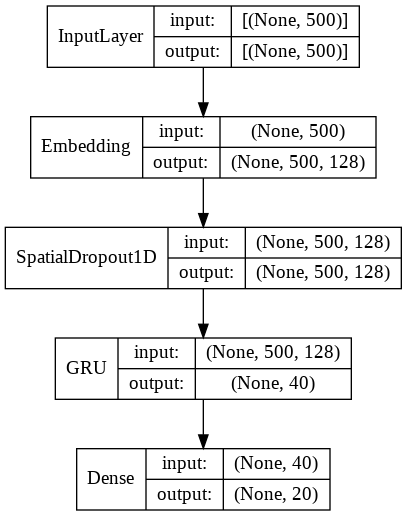

In [17]:
plot_model(model_gru, show_layer_names=False, show_shapes=True)

In [ ]:
model_gru_save_path = '/content/drive/MyDrive/mvi/best_model_gru1_all_data_dropout.h5'
checkpoint_callback = [ModelCheckpoint(model_gru_save_path, 
                                      monitor='val_accuracy',
                                      save_best_only=True,
                                      verbose=1),
                      EarlyStopping(monitor='val_loss', 
                                    mode='min', 
                                    verbose=1, 
                                    patience=10)]

In [ ]:
model_gru.fit(x_train, 
              Target_train, 
              epochs=100,
              batch_size=512,
              validation_split=0.2,
              callbacks=checkpoint_callback)

Epoch 1/100
2164/2164 [==============================] - ETA: 0s - loss: 0.1357 - accuracy: 0.6080 - auc: 0.9279
Epoch 00001: val_accuracy improved from -inf to 0.77866, saving model to /content/drive/MyDrive/mvi/best_model_gru1_all_data_dropout.h5
2164/2164 [==============================] - 389s 177ms/step - loss: 0.1357 - accuracy: 0.6080 - auc: 0.9279 - val_loss: 0.0768 - val_accuracy: 0.7787 - val_auc: 0.9795
Epoch 2/100
2164/2164 [==============================] - ETA: 0s - loss: 0.0736 - accuracy: 0.7811 - auc: 0.9808
Epoch 00002: val_accuracy improved from 0.77866 to 0.79295, saving model to /content/drive/MyDrive/mvi/best_model_gru1_all_data_dropout.h5
2164/2164 [==============================] - 381s 176ms/step - loss: 0.0736 - accuracy: 0.7811 - auc: 0.9808 - val_loss: 0.0686 - val_accuracy: 0.7930 - val_auc: 0.9835
Epoch 3/100
2164/2164 [==============================] - ETA: 0s - loss: 0.0679 - accuracy: 0.7919 - auc: 0.9837
Epoch 00003: val_accuracy improved from 0.79295 

#### GRU 2 layers



In [18]:
model_gru = Sequential()
model_gru.add(Embedding(word_count, 128, input_length=max_text_len))
model_gru.add(SpatialDropout1D(0.5))
model_gru.add(GRU(40, return_sequences=True))
model_gru.add(GRU(40))
model_gru.add(Dense(20, activation='sigmoid'))

In [19]:
model_gru.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy', 'AUC'])

In [ ]:
model_gru.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 500, 128)          1920000   
                                                                 
 spatial_dropout1d_1 (Spatia  (None, 500, 128)         0         
 lDropout1D)                                                     
                                                                 
 gru_1 (GRU)                 (None, 500, 40)           20400     
                                                                 
 gru_2 (GRU)                 (None, 40)                9840      
                                                                 
 dense (Dense)               (None, 20)                820       
                                                                 
Total params: 1,951,060
Trainable params: 1,951,060
Non-trainable params: 0
____________________________________________

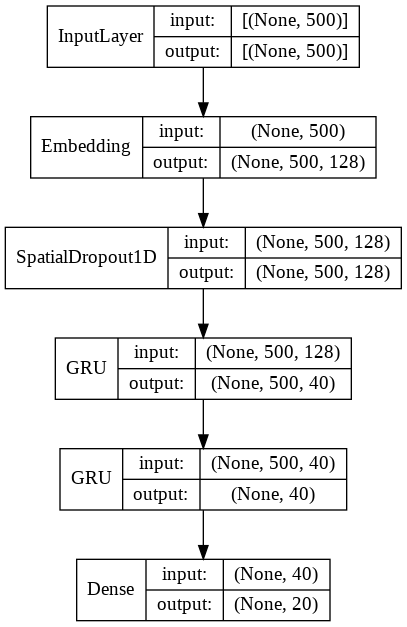

In [20]:
plot_model(model_gru, show_layer_names=False, show_shapes=True)

In [ ]:
model_gru_save_path = '/content/drive/MyDrive/mvi/best_model_gru2_all_data_dropout.h5'
checkpoint_callback = [ModelCheckpoint(model_gru_save_path, 
                                      monitor='val_accuracy',
                                      save_best_only=True,
                                      verbose=1),
                      EarlyStopping(monitor='val_loss', 
                                    mode='min', 
                                    verbose=1, 
                                    patience=10)]

In [ ]:
model_gru.fit(x_train, 
              Target_train, 
              epochs=100,
              batch_size=512,
              validation_split=0.2,
              callbacks=checkpoint_callback)

Epoch 1/100
2164/2164 [==============================] - ETA: 0s - loss: 0.1365 - accuracy: 0.6122 - auc: 0.9262
Epoch 00001: val_accuracy improved from -inf to 0.77288, saving model to /content/drive/MyDrive/mvi/best_model_gru2_all_data_dropout.h5
2164/2164 [==============================] - 481s 219ms/step - loss: 0.1365 - accuracy: 0.6122 - auc: 0.9262 - val_loss: 0.0838 - val_accuracy: 0.7729 - val_auc: 0.9752
Epoch 2/100
2164/2164 [==============================] - ETA: 0s - loss: 0.0776 - accuracy: 0.7769 - auc: 0.9785
Epoch 00002: val_accuracy improved from 0.77288 to 0.78689, saving model to /content/drive/MyDrive/mvi/best_model_gru2_all_data_dropout.h5
2164/2164 [==============================] - 466s 215ms/step - loss: 0.0776 - accuracy: 0.7769 - auc: 0.9785 - val_loss: 0.0709 - val_accuracy: 0.7869 - val_auc: 0.9822
Epoch 3/100
2164/2164 [==============================] - ETA: 0s - loss: 0.0693 - accuracy: 0.7873 - auc: 0.9830
Epoch 00003: val_accuracy improved from 0.78689 

In [ ]:
#model_gru = load_model('/content/drive/MyDrive/mvi/best_model_gru2_all_data_dropout.h5')

In [ ]:
model_gru.fit(x_train, 
              Target_train, 
              epochs=100,
              batch_size=512,
              validation_split=0.2,
              callbacks=checkpoint_callback)

Epoch 1/100
2164/2164 [==============================] - ETA: 0s - loss: 0.0539 - accuracy: 0.8131 - auc: 0.9900
Epoch 00001: val_accuracy improved from -inf to 0.80470, saving model to /content/drive/MyDrive/mvi/best_model_gru2_all_data_dropout.h5
2164/2164 [==============================] - 468s 213ms/step - loss: 0.0539 - accuracy: 0.8131 - auc: 0.9900 - val_loss: 0.0605 - val_accuracy: 0.8047 - val_auc: 0.9862
Epoch 2/100
2164/2164 [==============================] - ETA: 0s - loss: 0.0538 - accuracy: 0.8137 - auc: 0.9900
Epoch 00002: val_accuracy improved from 0.80470 to 0.80612, saving model to /content/drive/MyDrive/mvi/best_model_gru2_all_data_dropout.h5
2164/2164 [==============================] - 460s 212ms/step - loss: 0.0538 - accuracy: 0.8137 - auc: 0.9900 - val_loss: 0.0606 - val_accuracy: 0.8061 - val_auc: 0.9860
Epoch 3/100
2164/2164 [==============================] - ETA: 0s - loss: 0.0536 - accuracy: 0.8140 - auc: 0.9901
Epoch 00003: val_accuracy did not improve from 0

#### LSTM 1 layer

In [21]:
model_lstm = Sequential()
model_lstm.add(Embedding(word_count, 128, input_length=max_text_len))
model_lstm.add(SpatialDropout1D(0.5))
model_lstm.add(LSTM(40))
model_lstm.add(Dense(20, activation='sigmoid'))

In [22]:
model_lstm.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy', 'AUC'])

In [ ]:
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 128)          1920000   
                                                                 
 spatial_dropout1d (SpatialD  (None, 500, 128)         0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 40)                27040     
                                                                 
 dense (Dense)               (None, 20)                820       
                                                                 
Total params: 1,947,860
Trainable params: 1,947,860
Non-trainable params: 0
_________________________________________________________________


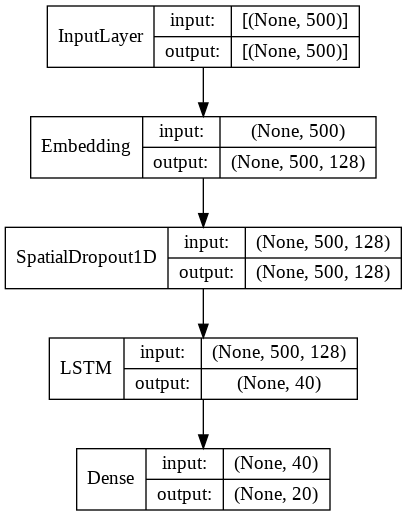

In [24]:
plot_model(model_lstm, show_layer_names=False, show_shapes=True)

In [ ]:
model_lstm_save_path = '/content/drive/MyDrive/mvi/best_model_lstm1_all_data_dropout.h5'
checkpoint_callback = [ModelCheckpoint(model_lstm_save_path, 
                                      monitor='val_accuracy',
                                      save_best_only=True,
                                      verbose=1),
                      EarlyStopping(monitor='val_loss', 
                                    mode='min', 
                                    verbose=1, 
                                    patience=10)]

In [ ]:
model_lstm.fit(x_train, 
              Target_train, 
              epochs=100,
              batch_size=512,
              validation_split=0.2,
              callbacks=checkpoint_callback)

Epoch 1/100
2164/2164 [==============================] - ETA: 0s - loss: 0.1560 - accuracy: 0.5660 - auc: 0.8996
Epoch 00001: val_accuracy improved from -inf to 0.76554, saving model to /content/drive/MyDrive/mvi/best_model_lstm1_all_data_dropout.h5
2164/2164 [==============================] - 289s 131ms/step - loss: 0.1560 - accuracy: 0.5660 - auc: 0.8996 - val_loss: 0.0890 - val_accuracy: 0.7655 - val_auc: 0.9713
Epoch 2/100
2164/2164 [==============================] - ETA: 0s - loss: 0.0792 - accuracy: 0.7741 - auc: 0.9776
Epoch 00002: val_accuracy improved from 0.76554 to 0.78855, saving model to /content/drive/MyDrive/mvi/best_model_lstm1_all_data_dropout.h5
2164/2164 [==============================] - 284s 131ms/step - loss: 0.0792 - accuracy: 0.7741 - auc: 0.9776 - val_loss: 0.0711 - val_accuracy: 0.7886 - val_auc: 0.9818
Epoch 3/100
2164/2164 [==============================] - ETA: 0s - loss: 0.0694 - accuracy: 0.7885 - auc: 0.9828
Epoch 00003: val_accuracy improved from 0.7885

#### LSTM 2 layers without dropout

In [28]:
model_lstm = Sequential()
model_lstm.add(Embedding(word_count, 128, input_length=max_text_len))
model_lstm.add(LSTM(40, return_sequences=True))
model_lstm.add(LSTM(40))
model_lstm.add(Dense(20, activation='sigmoid'))

In [29]:
model_lstm.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy', 'AUC'])

In [ ]:
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 128)          1920000   
                                                                 
 lstm (LSTM)                 (None, 500, 40)           27040     
                                                                 
 lstm_1 (LSTM)               (None, 40)                12960     
                                                                 
 dense (Dense)               (None, 20)                820       
                                                                 
Total params: 1,960,820
Trainable params: 1,960,820
Non-trainable params: 0
_________________________________________________________________


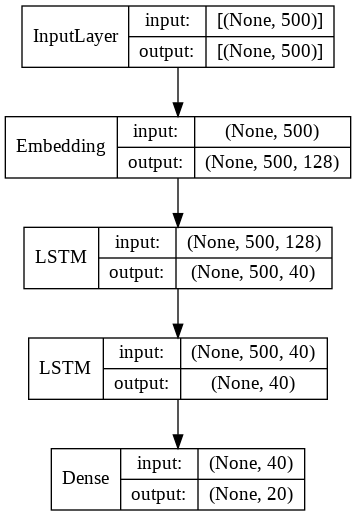

In [30]:
plot_model(model_lstm, show_layer_names=False, show_shapes=True)

In [ ]:
model_lstm_save_path = 'best_model_lstm2_all_data.h5'
checkpoint_callback = [ModelCheckpoint(model_lstm_save_path, 
                                      monitor='val_accuracy',
                                      save_best_only=True,
                                      verbose=1),
                      EarlyStopping(monitor='val_loss', 
                                    mode='min', 
                                    verbose=1, 
                                    patience=10)]

In [ ]:
history_lstm = model_lstm.fit(x_train, 
                              Target_train, 
                              epochs=100,
                              batch_size=512,
                              validation_split=0.2,
                              callbacks=checkpoint_callback)

Epoch 1/100
2164/2164 [==============================] - ETA: 0s - loss: 0.1796 - accuracy: 0.4495 - auc: 0.8589
Epoch 00001: val_accuracy improved from -inf to 0.71662, saving model to best_model_lstm2_all_data.h5
2164/2164 [==============================] - 475s 213ms/step - loss: 0.1796 - accuracy: 0.4495 - auc: 0.8589 - val_loss: 0.1073 - val_accuracy: 0.7166 - val_auc: 0.9571
Epoch 2/100
2164/2164 [==============================] - ETA: 0s - loss: 0.0857 - accuracy: 0.7627 - auc: 0.9737
Epoch 00002: val_accuracy improved from 0.71662 to 0.77893, saving model to best_model_lstm2_all_data.h5
2164/2164 [==============================] - 459s 212ms/step - loss: 0.0857 - accuracy: 0.7627 - auc: 0.9737 - val_loss: 0.0743 - val_accuracy: 0.7789 - val_auc: 0.9807
Epoch 3/100
2164/2164 [==============================] - ETA: 0s - loss: 0.0685 - accuracy: 0.7901 - auc: 0.9833
Epoch 00003: val_accuracy improved from 0.77893 to 0.79728, saving model to best_model_lstm2_all_data.h5
2164/2164 [

In [ ]:
#model_lstm = load_model('best_model_lstm.h5')

#### LSTM 2 layers with dropout

In [25]:
model_lstm = Sequential()
model_lstm.add(Embedding(word_count, 128, input_length=max_text_len))
model_lstm.add(SpatialDropout1D(0.5))
model_lstm.add(LSTM(40, return_sequences=True))
model_lstm.add(LSTM(40))
model_lstm.add(Dense(20, activation='sigmoid'))

In [26]:
model_lstm.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy', 'AUC'])

In [ ]:
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 128)          1920000   
                                                                 
 spatial_dropout1d (SpatialD  (None, 500, 128)         0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 500, 40)           27040     
                                                                 
 lstm_1 (LSTM)               (None, 40)                12960     
                                                                 
 dense (Dense)               (None, 20)                820       
                                                                 
Total params: 1,960,820
Trainable params: 1,960,820
Non-trainable params: 0
______________________________________________

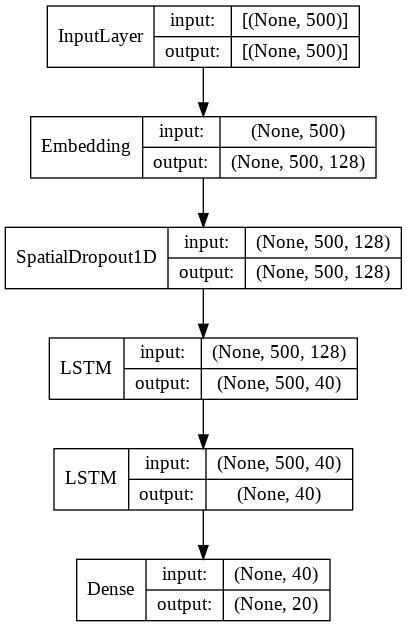

In [27]:
plot_model(model_lstm, show_layer_names=False, show_shapes=True)

In [ ]:
model_lstm_save_path = '/content/drive/MyDrive/mvi/best_model_lstm2_all_data_with_dropout.h5'
checkpoint_callback = [ModelCheckpoint(model_lstm_save_path, 
                                      monitor='val_accuracy',
                                      save_best_only=True,
                                      verbose=1),
                      EarlyStopping(monitor='val_accuracy',  
                                    verbose=1, 
                                    patience=10)]

In [ ]:
history_lstm = model_lstm.fit(x_train, 
                              Target_train, 
                              epochs=100,
                              batch_size=512,
                              validation_split=0.2,
                              callbacks=checkpoint_callback)

Epoch 1/100
2164/2164 [==============================] - ETA: 0s - loss: 0.1741 - accuracy: 0.4608 - auc: 0.8681
Epoch 00001: val_accuracy improved from -inf to 0.74911, saving model to /content/drive/MyDrive/mvi/best_model_lstm2_all_data_with_dropout.h5
2164/2164 [==============================] - 719s 329ms/step - loss: 0.1741 - accuracy: 0.4608 - auc: 0.8681 - val_loss: 0.0953 - val_accuracy: 0.7491 - val_auc: 0.9675
Epoch 2/100
2164/2164 [==============================] - ETA: 0s - loss: 0.0827 - accuracy: 0.7657 - auc: 0.9757
Epoch 00002: val_accuracy improved from 0.74911 to 0.78300, saving model to /content/drive/MyDrive/mvi/best_model_lstm2_all_data_with_dropout.h5
2164/2164 [==============================] - 708s 327ms/step - loss: 0.0827 - accuracy: 0.7657 - auc: 0.9757 - val_loss: 0.0728 - val_accuracy: 0.7830 - val_auc: 0.9815
Epoch 3/100
2164/2164 [==============================] - ETA: 0s - loss: 0.0703 - accuracy: 0.7875 - auc: 0.9824
Epoch 00003: val_accuracy improved f

In [31]:
model_lstm = load_model('/content/drive/MyDrive/mvi/best_model_lstm2_all_data_with_dropout.h5')

In [ ]:
history_lstm = model_lstm.fit(x_train, 
                              Target_train, 
                              epochs=100,
                              batch_size=512,
                              validation_split=0.2,
                              callbacks=checkpoint_callback)

Epoch 1/100
2164/2164 [==============================] - ETA: 0s - loss: 0.0542 - accuracy: 0.8143 - auc: 0.9899
Epoch 00001: val_accuracy improved from -inf to 0.80121, saving model to /content/drive/MyDrive/mvi/best_model_lstm2_all_data_with_dropout.h5
2164/2164 [==============================] - 500s 228ms/step - loss: 0.0542 - accuracy: 0.8143 - auc: 0.9899 - val_loss: 0.0605 - val_accuracy: 0.8012 - val_auc: 0.9858
Epoch 2/100
2164/2164 [==============================] - ETA: 0s - loss: 0.0540 - accuracy: 0.8147 - auc: 0.9900
Epoch 00002: val_accuracy improved from 0.80121 to 0.80499, saving model to /content/drive/MyDrive/mvi/best_model_lstm2_all_data_with_dropout.h5
2164/2164 [==============================] - 492s 227ms/step - loss: 0.0540 - accuracy: 0.8147 - auc: 0.9900 - val_loss: 0.0598 - val_accuracy: 0.8050 - val_auc: 0.9864
Epoch 3/100
2164/2164 [==============================] - ETA: 0s - loss: 0.0538 - accuracy: 0.8151 - auc: 0.9901
Epoch 00003: val_accuracy did not im

In [ ]:
#model_lstm = load_model('/content/drive/MyDrive/mvi/best_model_lstm2_all_data_with_dropout.h5')

In [ ]:
history_lstm = model_lstm.fit(x_train, 
                              Target_train, 
                              epochs=100,
                              batch_size=512,
                              validation_split=0.2,
                              callbacks=checkpoint_callback)

Epoch 1/100
2164/2164 [==============================] - ETA: 0s - loss: 0.0522 - accuracy: 0.8182 - auc: 0.9906
Epoch 00001: val_accuracy improved from -inf to 0.80486, saving model to /content/drive/MyDrive/mvi/best_model_lstm2_all_data_with_dropout.h5
2164/2164 [==============================] - 715s 328ms/step - loss: 0.0522 - accuracy: 0.8182 - auc: 0.9906 - val_loss: 0.0602 - val_accuracy: 0.8049 - val_auc: 0.9859
Epoch 2/100
2164/2164 [==============================] - ETA: 0s - loss: 0.0521 - accuracy: 0.8183 - auc: 0.9907
Epoch 00002: val_accuracy improved from 0.80486 to 0.80491, saving model to /content/drive/MyDrive/mvi/best_model_lstm2_all_data_with_dropout.h5
2164/2164 [==============================] - 710s 328ms/step - loss: 0.0521 - accuracy: 0.8183 - auc: 0.9907 - val_loss: 0.0601 - val_accuracy: 0.8049 - val_auc: 0.9859
Epoch 3/100
2164/2164 [==============================] - ETA: 0s - loss: 0.0520 - accuracy: 0.8184 - auc: 0.9908
Epoch 00003: val_accuracy did not im

In [6]:
model_lstm = load_model('/content/drive/MyDrive/mvi/best_model_lstm2_all_data_with_dropout.h5')

In [ ]:
history_lstm = model_lstm.fit(x_train, 
                              Target_train, 
                              epochs=100,
                              batch_size=512,
                              validation_split=0.2,
                              callbacks=checkpoint_callback)

Epoch 1/100
2164/2164 [==============================] - ETA: 0s - loss: 0.0509 - accuracy: 0.8206 - auc: 0.9912
Epoch 00001: val_accuracy improved from -inf to 0.80438, saving model to /content/drive/MyDrive/mvi/best_model_lstm2_all_data_with_dropout.h5
2164/2164 [==============================] - 485s 221ms/step - loss: 0.0509 - accuracy: 0.8206 - auc: 0.9912 - val_loss: 0.0604 - val_accuracy: 0.8044 - val_auc: 0.9854
Epoch 2/100
2164/2164 [==============================] - ETA: 0s - loss: 0.0508 - accuracy: 0.8209 - auc: 0.9912
Epoch 00002: val_accuracy did not improve from 0.80438
2164/2164 [==============================] - 476s 220ms/step - loss: 0.0508 - accuracy: 0.8209 - auc: 0.9912 - val_loss: 0.0605 - val_accuracy: 0.8021 - val_auc: 0.9855
Epoch 3/100
2164/2164 [==============================] - ETA: 0s - loss: 0.0507 - accuracy: 0.8209 - auc: 0.9913
Epoch 00003: val_accuracy did not improve from 0.80438
2164/2164 [==============================] - 477s 220ms/step - loss: 0.

#### Testing

In [7]:
Sequences_test = tokenizer.texts_to_sequences(Text_test)

In [8]:
x_test = pad_sequences(Sequences_test, maxlen=max_text_len)

#Evaluation on test set

In [10]:
score = model_lstm.evaluate(x_test, Target_test, verbose = 0) 

print('Test loss:', score[0]) 
print('Test accuracy:', score[1])

Test loss: 0.060648974031209946
Test accuracy: 0.8056646585464478
